In [1]:
# -----------------------------------
# Imports and Device Setup
# -----------------------------------
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve
import seaborn as sns

# Imports and Device Setup

In [2]:
# Device config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


## Custom Dataset: CatsDogsDataset
This custom PyTorch Dataset class loads a subset of 5000 images from the Dogs vs Cats dataset — specifically:

- 2500 cat images

- 2500 dog images

It performs the following:

- Shuffles the dataset

- Applies specified image transformations (resize, tensor conversion, etc.)

- Assigns binary labels (0 for cat, 1 for dog)

This class ensures consistency in training and validation splits and supports flexible preprocessing.

In [3]:
# -----------------------------------
# Custom Dataset - 2500 Cats + 2500 Dogs
# -----------------------------------
class CatsDogsDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        all_imgs = [f for f in os.listdir(img_dir) if f.endswith('.jpg')]
        cat_imgs = [f for f in all_imgs if "cat" in f][:2500]
        dog_imgs = [f for f in all_imgs if "dog" in f][:2500]
        self.imgs = cat_imgs + dog_imgs
        np.random.shuffle(self.imgs)

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img_name = self.imgs[idx]
        label = 0 if "cat" in img_name else 1
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

## Data Loading Pipeline
This section prepares the dataset for training and validation:

**Applies image transformations:**

- Resizes images to 128×128 pixels

- Converts them to PyTorch tensors

- Loads images using the custom CatsDogsDataset class

- Performs a 90-10 split into training and validation sets

**Wraps the datasets in PyTorch DataLoader with:** 

- Batch size of 32

- Shuffling enabled for training

This sets up the input pipeline for both custom and pretrained model training.

In [4]:
# -----------------------------------
# Data Loading
# -----------------------------------
import os
from torchvision import transforms
from torch.utils.data import DataLoader, random_split

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

base_dir = os.path.join(os.getcwd(), "train", "train")
dataset = CatsDogsDataset(base_dir, transform=transform)

train_len = int(0.9 * len(dataset))
val_len = len(dataset) - train_len
train_dataset, val_dataset = random_split(dataset, [train_len, val_len])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


## Exploratory Data Analysis (EDA)
In this section, we conduct a brief exploratory analysis of the dataset to better understand its structure and distribution prior to training:

**Class Distribution:**
- We count the number of images for each class (cats and dogs) and visualize the balance using a bar chart. This helps confirm that the dataset is reasonably balanced and suitable for binary classification.

**Sample Visualization:**
- A few representative images are displayed from the dataset to verify that the loading and transformations are working correctly. This step also helps build intuition around the visual differences between the two classes.

**Channel Statistics (Mean and Standard Deviation):**
- Using a subset of 100 images, we compute the mean and standard deviation for each RGB channel. These values are useful for normalizing the dataset, which can improve training stability and convergence.

Performing EDA ensures the data is clean, well-understood, and ready for use in model development.



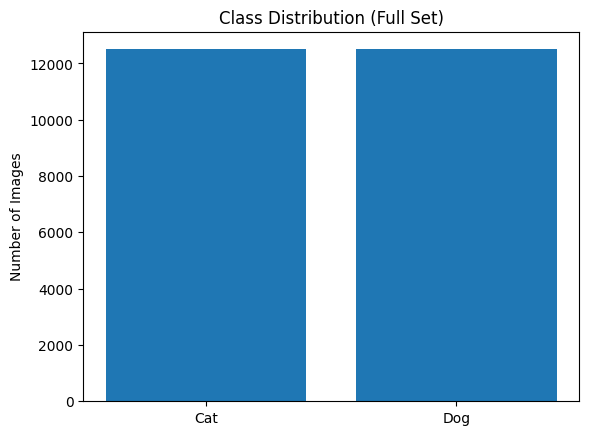

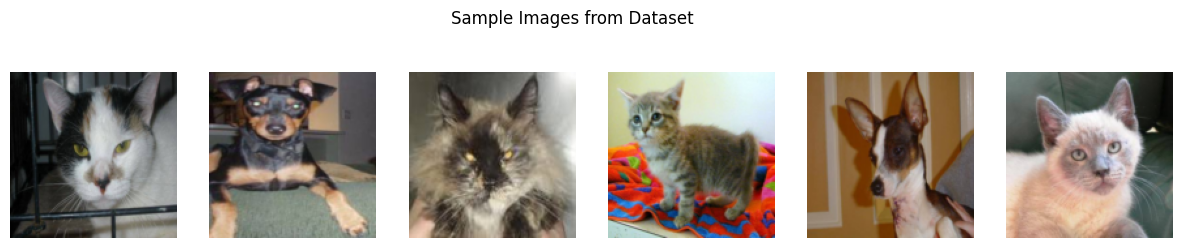

Mean pixel values per channel: tensor([0.4813, 0.4493, 0.4158])
Std pixel values per channel: tensor([0.2607, 0.2503, 0.2533])


In [5]:
# -----------------------------------
# EDA - Class Distribution, Image Sizes, Channel Statistics
# -----------------------------------
import os
import matplotlib.pyplot as plt
import torch

# Use the same base_dir as in data loading
image_dir = os.path.join(os.getcwd(), "train", "train")

# Class distribution
labels = [0 if 'cat' in f else 1 for f in os.listdir(image_dir) if f.endswith('.jpg')]
plt.bar(['Cat', 'Dog'], [labels.count(0), labels.count(1)])
plt.title("Class Distribution (Full Set)")
plt.ylabel("Number of Images")
plt.show()

# Sample images
display_samples = [dataset[i][0] for i in range(6)]
fig, axes = plt.subplots(1, 6, figsize=(15, 3))
for i, img in enumerate(display_samples):
    axes[i].imshow(img.permute(1, 2, 0))
    axes[i].axis('off')
plt.suptitle("Sample Images from Dataset")
plt.show()

# Channel mean/std (on a subset of 100 images)
sample_tensor = torch.stack([dataset[i][0] for i in range(100)])
mean = sample_tensor.mean(dim=(0, 2, 3))
std = sample_tensor.std(dim=(0, 2, 3))
print("Mean pixel values per channel:", mean)
print("Std pixel values per channel:", std)


## Image Size Distribution (Before Resizing)
- To gain insight into the original dimensions of the dataset, we analyze the width and height of the first 500 images. This helps assess whether resizing is necessary for consistent model input.

- The sizes are extracted from raw images before any transformation.

- Histograms are plotted for both widths and heights, allowing us to observe:

- The variation in image dimensions

- How uniform (or inconsistent) the dataset is in terms of resolution

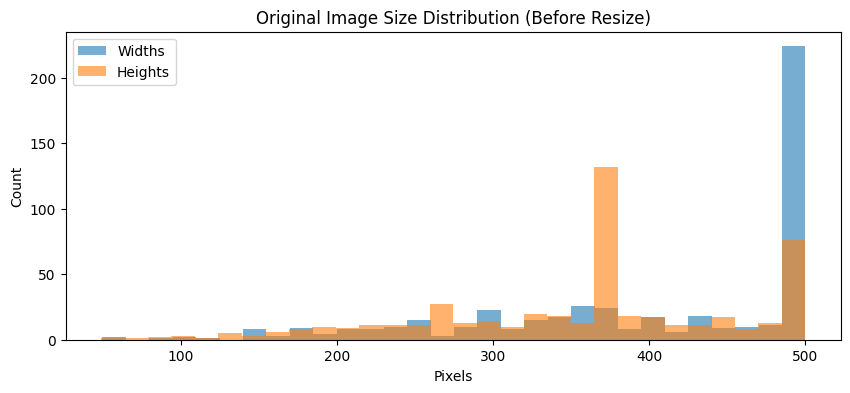

In [6]:
from PIL import Image
import os
import matplotlib.pyplot as plt

img_dir = os.path.join(os.getcwd(), "train", "train")

# Collect sizes of first 500 images
sizes = [Image.open(os.path.join(img_dir, f)).size for f in os.listdir(img_dir) if f.endswith('.jpg')][:500]
widths, heights = zip(*sizes)

# Plot histogram
plt.figure(figsize=(10, 4))
plt.hist(widths, bins=30, alpha=0.6, label='Widths')
plt.hist(heights, bins=30, alpha=0.6, label='Heights')
plt.title("Original Image Size Distribution (Before Resize)")
plt.xlabel("Pixels")
plt.ylabel("Count")
plt.legend()
plt.show()


## Image Size Distribution (After Resizing)
- After applying a resizing transformation to standardize all input images to **128×128 pixels**, we verify that the transformation was applied correctly by re-checking the dimensions of a subset of the dataset.

- The plot shows the distribution of image heights and widths post-transformation.

As expected, both height and width values cluster tightly at **128 pixels**, confirming that the resize operation was successful and consistent.

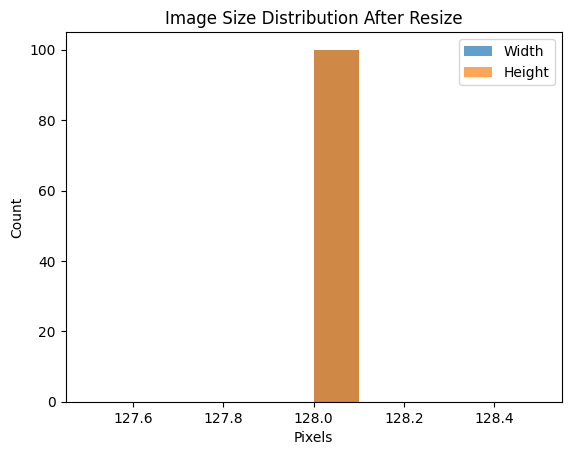

In [7]:
resized_shapes = [dataset[i][0].shape[1:] for i in range(100)]  # shape = (3, H, W)
heights, widths = zip(*resized_shapes)

plt.hist(widths, bins=10, alpha=0.7, label='Width')
plt.hist(heights, bins=10, alpha=0.7, label='Height')
plt.title("Image Size Distribution After Resize")
plt.xlabel("Pixels")
plt.ylabel("Count")
plt.legend()
plt.show()


## Pixel Intensity Distribution (Grayscale)
- To further understand the visual properties of the dataset, we examine the pixel intensity distribution of a sample image converted to **grayscale**.

- The image is loaded in **L-mode**, representing pixel intensities on a scale from **0 (black)** to **255 (white)**.

- A **histogram** is plotted to show how frequently each intensity value occurs.

This analysis provides insight into the lighting, contrast, and brightness characteristics of the original dataset, which can be useful when designing preprocessing steps such as normalization or histogram equalization.

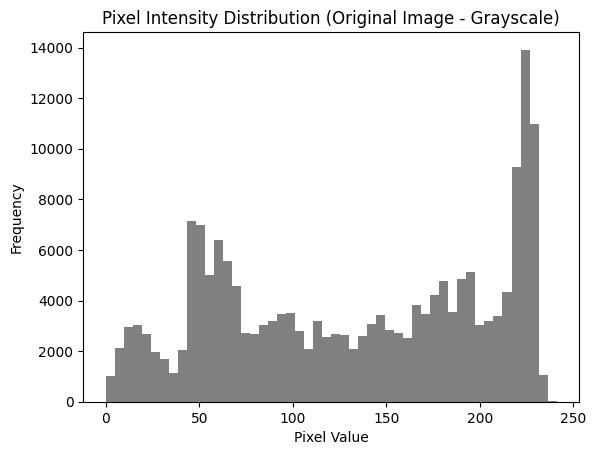

In [8]:
img_raw = Image.open(os.path.join(img_dir, os.listdir(img_dir)[0])).convert("L")
plt.hist(np.array(img_raw).ravel(), bins=50, color='gray')
plt.title("Pixel Intensity Distribution (Original Image - Grayscale)")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.show()


## Pixel Intensity Distribution (After Transformation)
- In this step, we examine the pixel intensity distribution of a sample image after applying preprocessing transformations, such as resizing and tensor conversion.

- The **image tensor** is converted back to a **NumPy array** for visualization.

- A histogram of pixel values is plotted to analyze how the transformation process affects the pixel distribution.

This analysis helps confirm that the transformation pipeline preserves relevant visual features and doesn't introduce unintended distortions. It also serves as a sanity check before feeding the data into the model for training.

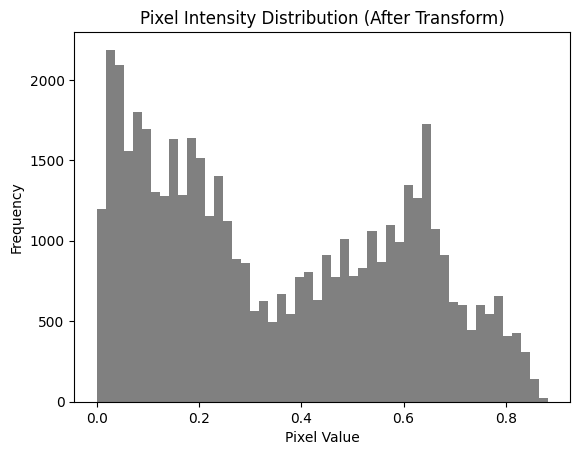

In [9]:
img_tensor = dataset[0][0]  # shape: (3, 128, 128)
img_np = img_tensor.permute(1, 2, 0).numpy()

plt.hist(img_np.ravel(), bins=50, color='gray')
plt.title("Pixel Intensity Distribution (After Transform)")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.show()


## Label Distribution in Dataset
To verify the balance of the dataset, we calculate the distribution of class labels (cats and dogs) using Python’s Counter from the collections module.

- 0 corresponds to cats

- 1 corresponds to dogs

The output confirms a perfectly balanced dataset with:

- 2500 cat images

- 2500 dog images

Ensuring label balance is critical for supervised learning tasks, as it helps prevent model bias toward one class during training.

In [10]:
from collections import Counter
print("Label distribution in loaded dataset:", Counter([dataset[i][1] for i in range(len(dataset))]))


Label distribution in loaded dataset: Counter({0: 2500, 1: 2500})


# Model 1: Custom Vanilla CNN
This is a lightweight convolutional neural network (SimpleCNN) built from scratch for binary classification (cats vs. dogs).

**Architecture Summary:**
- **Conv Layer 1:** 3→32 filters, kernel size 3, ReLU + MaxPooling

- **Conv Layer 2:** 32→64 filters, kernel size 3, ReLU + MaxPooling

- **Flatten** → FC: Fully connected layer with 128 units + Dropout (30%)

- **Output Layer:** Linear layer with 2 output logits

This model provides a fast, efficient baseline before transitioning to deeper, pretrained networks like **VGG16**.

In [11]:
# -----------------------------------
# Model 1: Vanilla CNN
# -----------------------------------
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.fc1 = nn.Linear(64 * 30 * 30, 128)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 30 * 30)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

##  Fine-tuned VGG16 with frozen layers and a custom 2-class head

In [14]:
import os
import io
import contextlib
from torchvision.models import vgg16, VGG16_Weights
import torch.nn as nn

os.environ['TORCH_HOME'] = os.path.join(os.getcwd(), '.torch_cache')

with contextlib.redirect_stdout(io.StringIO()), contextlib.redirect_stderr(io.StringIO()):
    weights = VGG16_Weights.DEFAULT
    vgg16_model = vgg16(weights=weights)

# Final model setup
for param in vgg16_model.features.parameters():
    param.requires_grad = False

vgg16_model.classifier[6] = nn.Linear(4096, 2)
vgg16_model = vgg16_model.to(device)


## Training Function
**Trains the model over multiple epochs, computes loss, updates weights, and evaluates accuracy on the validation set each epoch**.

In [16]:
# -----------------------------------
# Training Function
# -----------------------------------
def train_model(model, train_loader, val_loader, criterion, optimizer, model_name, epochs=5):
    best_acc = 0
    model.to(device)
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Validation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        val_acc = correct / total
        print(f"Epoch {epoch+1}, Loss: {running_loss:.4f}, Val Accuracy: {val_acc:.4f}")
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), model_name)

## Training Both Models
Both the SimpleCNN and VGG16 models were trained using:
**CrossEntropyLoss:**
- This loss function is commonly used for multi-class (including binary) classification. It measures the distance between the predicted class probabilities and the true labels. Lower loss indicates better prediction accuracy.

**Adam Optimizer (Adaptive Moment Estimation):**
- Adam is an efficient gradient-based optimization algorithm that combines the benefits of Momentum and RMSProp. It adapts the learning rate for each parameter dynamically and typically leads to faster convergence.

Different learning rates were used for each model:

- SimpleCNN: lr = **0.001**

- VGG16 (fine-tuned): lr = 0.0001 — smaller, to avoid disrupting pre-trained features.

Model checkpoints were saved (.pt files) for later evaluation and comparison.

In [17]:
# -----------------------------------
# Train Both Models
# -----------------------------------
cnn = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=0.001)
print("Model Trained before VGG fine tuning")
train_model(cnn, train_loader, val_loader, criterion, optimizer, "best_simplecnn.pt")

vgg16 = models.vgg16(pretrained=True)
for param in vgg16.features.parameters():
    param.requires_grad = False
vgg16.classifier[6] = nn.Linear(4096, 2)
vgg16 = vgg16.to(device)
optimizer = optim.Adam(vgg16.classifier.parameters(), lr=0.0001)
print("Model trained after VGG fine tuning")
train_model(vgg16, train_loader, val_loader, criterion, optimizer, "best_vgg16.pt")

Model Trained before VGG fine tuning
Epoch 1, Loss: 105.0945, Val Accuracy: 0.5660
Epoch 2, Loss: 95.2555, Val Accuracy: 0.5960
Epoch 3, Loss: 92.4156, Val Accuracy: 0.5940
Epoch 4, Loss: 85.8281, Val Accuracy: 0.6400
Epoch 5, Loss: 78.7524, Val Accuracy: 0.6640
Model trained after VGG fine tuning
Epoch 1, Loss: 30.5956, Val Accuracy: 0.9220
Epoch 2, Loss: 16.7644, Val Accuracy: 0.9120
Epoch 3, Loss: 12.2722, Val Accuracy: 0.9160
Epoch 4, Loss: 7.3132, Val Accuracy: 0.9100
Epoch 5, Loss: 6.3571, Val Accuracy: 0.9240


## Evaluated both models using accuracy, confusion matrix, precision-recall, and classification report

              precision    recall  f1-score   support

         Cat       0.66      0.73      0.69       258
         Dog       0.67      0.60      0.63       242

    accuracy                           0.66       500
   macro avg       0.67      0.66      0.66       500
weighted avg       0.66      0.66      0.66       500



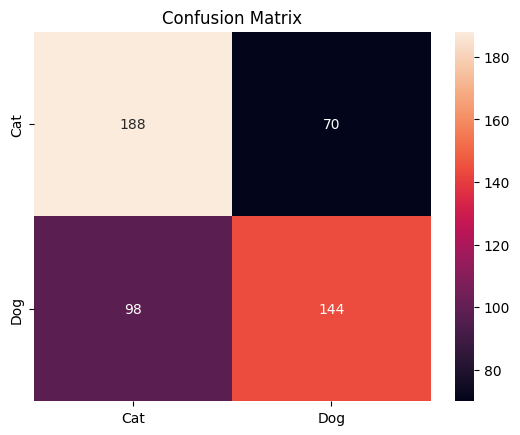

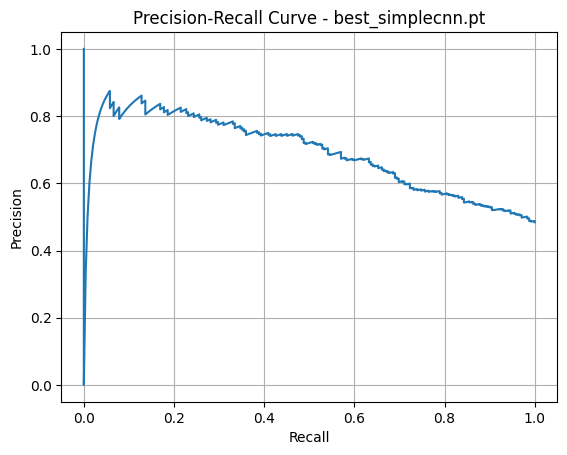

              precision    recall  f1-score   support

         Cat       0.90      0.97      0.93       258
         Dog       0.96      0.88      0.92       242

    accuracy                           0.92       500
   macro avg       0.93      0.92      0.92       500
weighted avg       0.93      0.92      0.92       500



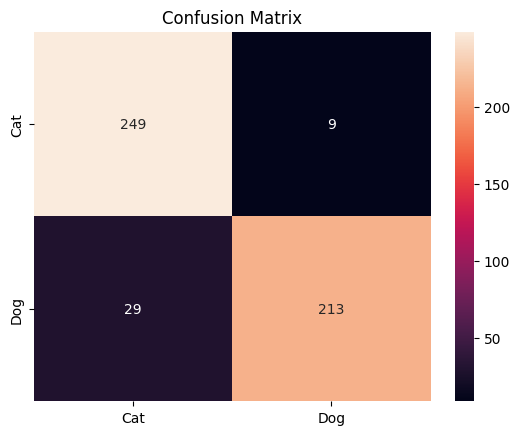

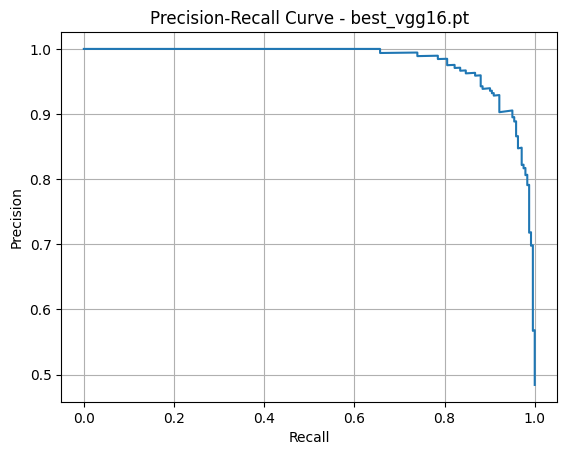

In [18]:
# -----------------------------------
# Evaluation Function
# -----------------------------------
def evaluate(model, loader, model_name):
    model.load_state_dict(torch.load(model_name))
    model.to(device)
    model.eval()
    y_true, y_pred, y_scores = [], [], []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(probs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            y_scores.extend(probs[:, 1].cpu().numpy())

    print(classification_report(y_true, y_pred, target_names=['Cat', 'Dog']))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
    plt.title("Confusion Matrix")
    plt.show()

    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    plt.plot(recall, precision)
    plt.title(f"Precision-Recall Curve - {model_name}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.grid()
    plt.show()

evaluate(SimpleCNN(), val_loader, "best_simplecnn.pt")
evaluate(vgg16, val_loader, "best_vgg16.pt")

## Identified and displayed sample misclassifications for both models

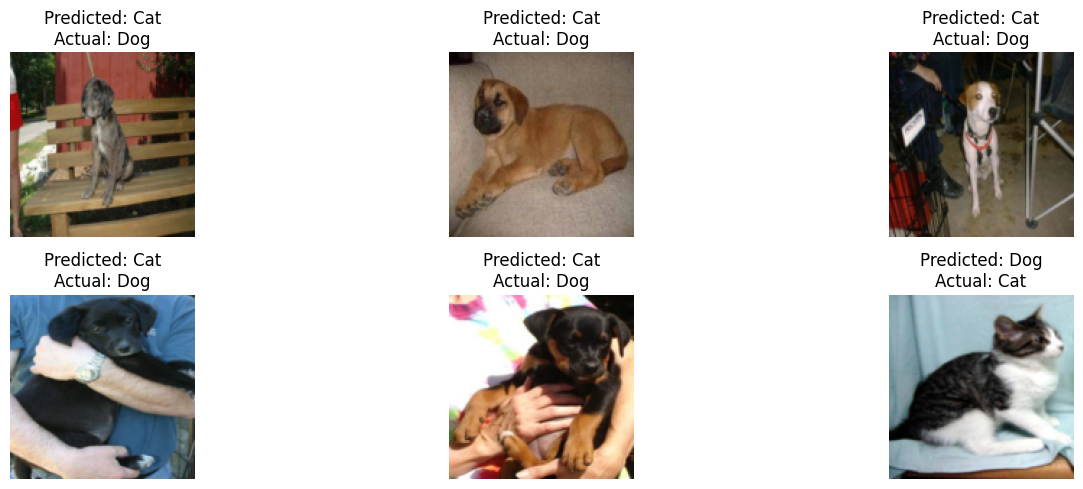

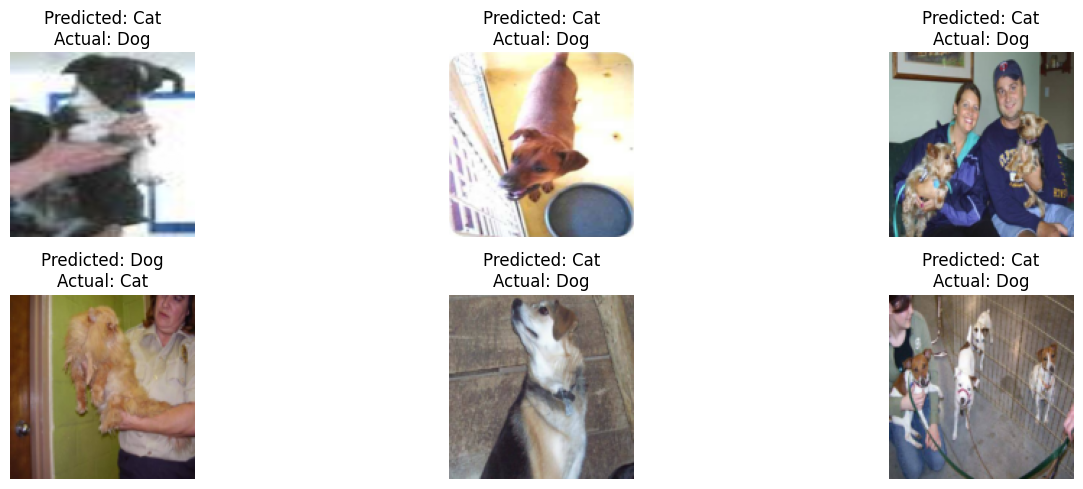

In [19]:
def show_misclassified(model, loader, model_name, max_images=6):
    model.load_state_dict(torch.load(model_name))
    model.to(device)
    model.eval()
    shown = 0
    images_to_show = []
    titles = []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            for img, pred, true in zip(images, preds, labels):
                if pred != true and shown < max_images:
                    images_to_show.append(img.cpu())
                    titles.append(f"Predicted: {'Dog' if pred==1 else 'Cat'}\nActual: {'Dog' if true==1 else 'Cat'}")
                    shown += 1
                if shown >= max_images:
                    break
            if shown >= max_images:
                break

    # Plot in gallery format
    cols = 3
    rows = int(np.ceil(max_images / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5))
    for i in range(rows * cols):
        if i < len(images_to_show):
            img = images_to_show[i].permute(1, 2, 0)
            axes[i // cols, i % cols].imshow(img)
            axes[i // cols, i % cols].set_title(titles[i])
            axes[i // cols, i % cols].axis('off')
        else:
            axes[i // cols, i % cols].axis('off')
    plt.tight_layout()
    plt.show()

show_misclassified(SimpleCNN(), val_loader, "best_simplecnn.pt")
show_misclassified(vgg16, val_loader, "best_vgg16.pt")


## Test Dataset Class (Unlabeled Images)
This custom PyTorch dataset is designed to handle unlabeled test images:

- Initializes with a given directory of .jpg images

- Sorts the filenames to maintain order (ex 1.jpg, 2.jpg, ...)

- Applies image transformations (like resizing or normalization)

- Returns both the processed image and its filename for tracking predictions

In [20]:
# -----------------------------------
# Dataset for Test Folder (Unlabeled Images)
# -----------------------------------
class TestDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.imgs = sorted([f for f in os.listdir(img_dir) if f.endswith('.jpg')])

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img_name = self.imgs[idx]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, img_name

## Load Test Data 

In [29]:
# -----------------------------------
# Load Test Folder 
# -----------------------------------
import os

# Construct path relative to the current working directory
test_dir = os.path.join(os.getcwd(), "test1", "test1")  # test1/test1 folder inside project

test_dataset = TestDataset(test_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


## Visualize Test Predictions in a Gallery
This function loads a saved model and generates predictions on unlabeled test images, then displays a selection of them in a grid format.

- It shows predicted labels (Cat or Dog) for each image.

- Predictions are overlaid on the images along with the filename.

- The output helps visually assess the model's behavior on unseen data.

In [30]:
# -----------------------------------
# Visualize Test Predictions in a Gallery
# -----------------------------------
def show_test_predictions(model, test_loader, model_name, max_images=6):
    model.load_state_dict(torch.load(model_name))
    model.to(device)
    model.eval()
    
    images_to_show = []
    titles = []
    shown = 0

    with torch.no_grad():
        for images, filenames in test_loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            for img, pred, fname in zip(images, preds, filenames):
                if shown >= max_images:
                    break
                label = 'Dog' if pred == 1 else 'Cat'
                images_to_show.append(img.cpu())
                titles.append(f"Predicted: {label}\nFile: {fname}")
                shown += 1

            if shown >= max_images:
                break

    # Plot in gallery format
    cols = 3
    rows = int(np.ceil(max_images / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5))
    for i in range(rows * cols):
        if i < len(images_to_show):
            img = images_to_show[i].permute(1, 2, 0)
            axes[i // cols, i % cols].imshow(img)
            axes[i // cols, i % cols].set_title(titles[i], fontsize=10)
            axes[i // cols, i % cols].axis('off')
        else:
            axes[i // cols, i % cols].axis('off')
    plt.tight_layout()
    plt.show()


## Model Prediction Comparison: SimpleCNN vs. VGG16
- In the first gallery generated in output, we can see that the SimpleCNN model predicted all images as cats, even though a couple of them (like 1.jpg and 1000.jpg) are clearly dogs.

- The second gallery generated in output shows predictions from the fine-tuned VGG16, which correctly identifies those same dog images.

**This small example highlights how VGG16's pretrained features help it better understand visual patterns, making it more reliable on unseen test data compared to a basic CNN trained from scratch.**



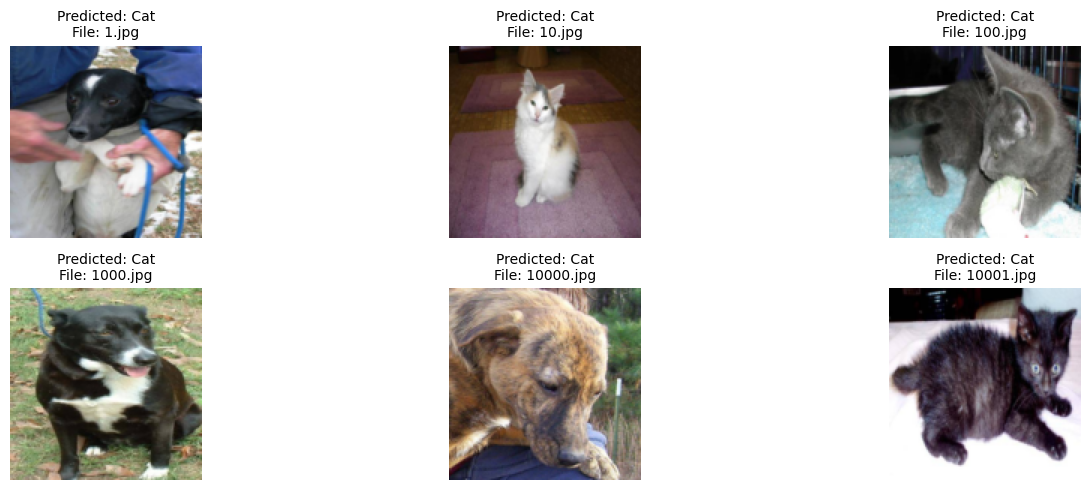

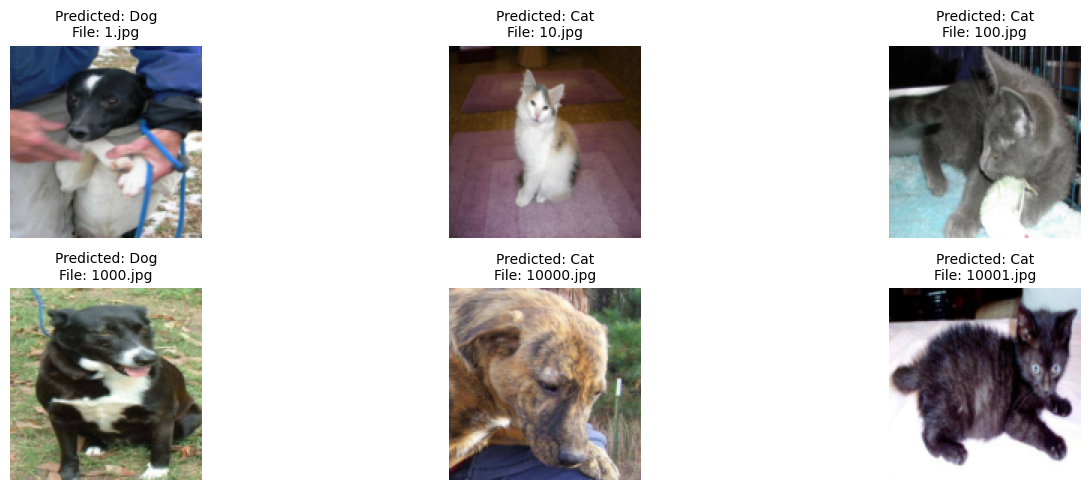

In [34]:
show_test_predictions(SimpleCNN(), test_loader, "best_simplecnn.pt")
show_test_predictions(vgg16, test_loader, "best_vgg16.pt")

## Conclusion

In [33]:

print("""
Conclusion:

- We explored a balanced subset (5000 images) of the Dogs vs Cats dataset.
- EDA showed equal class distribution and consistent image sizes.
- A custom CNN and fine-tuned VGG16 were trained and evaluated.
- VGG16 achieved better precision-recall performance overall.
- Misclassified images typically involved blurred or low-contrast pets.
- Further improvement could be done using data augmentation or more epochs with early stopping.
""")



Conclusion:

- We explored a balanced subset (5000 images) of the Dogs vs Cats dataset.
- EDA showed equal class distribution and consistent image sizes.
- A custom CNN and fine-tuned VGG16 were trained and evaluated.
- VGG16 achieved better precision-recall performance overall.
- Misclassified images typically involved blurred or low-contrast pets.
- Further improvement could be done using data augmentation or more epochs with early stopping.

